In [1]:
# Import or install Sionna
try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt

# Other imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

no_preview = True # Toggle to False to use the preview widget

# Import relevant components from Sionna RT
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera,\
                      PathSolver, RadioMapSolver, subcarrier_frequencies
                      
from sionnautils.miutils import CoverageMapPlanner, replace_material, assign_material
from matplotlib.colors import ListedColormap
from sionna.phy.channel import subcarrier_frequencies, cir_to_ofdm_channel, cir_to_time_channel, \
                               time_lag_discrete_time_channel, ApplyOFDMChannel, ApplyTimeChannel, \
                               OFDMChannel, TimeChannel


from sionna.phy.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer, PilotPattern,\
                            OFDMModulator, OFDMDemodulator, RZFPrecoder, RemoveNulledSubcarriers

jitc_llvm_init(): LLVM API initialization failed ..
2025-10-08 18:38:37.749040: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 18:38:37.768296: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-08 18:38:37.768313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-08 18:38:37.768955: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-08 18:38:37

In [2]:
scene = load_scene(sionna.rt.scene.simple_street_canyon, merge_shapes=True)
for name, obj in scene.objects.items():
    print(f'{name:<15}{obj.radio_material.name}')

floor          concrete
building_2     brick
no-name-1      marble
building_6     wood
no-name-2      glass


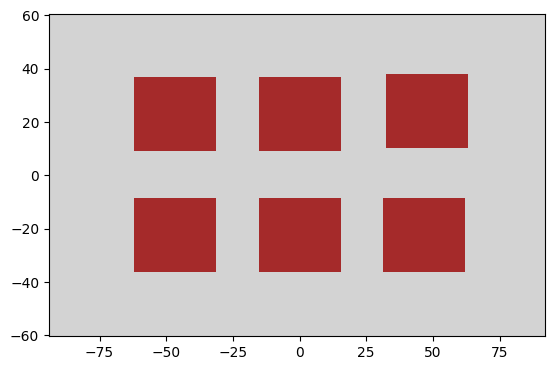

In [3]:
grid_size = 1.0
cm = CoverageMapPlanner(scene._scene, grid_size=grid_size)
cm.set_grid()
cm.compute_grid_attributes()
x_min, x_max = cm.x[0], cm.x[-1]
y_min, y_max = cm.y[0], cm.y[-1]
W_WE = x_max - x_min   # width (East-West)
L_NS = y_max - y_min   # length (North-South)
bbox = [-W_WE/2, W_WE/2, -L_NS/2, L_NS/2]
extent = [cm.x[0], cm.x[-1], cm.y[0], cm.y[-1]]
colors = ['lightgray', 'brown']
cmap = ListedColormap(colors)
# building = (cm.bldg_grid) & cm.in_region
outdoor = (cm.bldg_grid==False) 
building = (cm.bldg_grid) 
point_type = outdoor + 2*building
point_type = point_type.astype(int)
point_type = np.flipud(point_type)
plt.imshow(point_type, cmap=cmap, interpolation='nearest', extent=extent)

In [4]:
replace_material(scene, old_name="glass", new_name="metal")

Replacement complete: glass -> metal, updated 1 objects


1

In [5]:
bs_rows = 8
bs_cols = 8
ue_rows = 1
ue_cols = 1
frequency = 10e9

In [6]:

bs_array = PlanarArray(
            num_rows = bs_rows,
            num_cols = bs_cols,
            vertical_spacing=0.5,
            horizontal_spacing=0.5,
            polarization="V",
            pattern="tr38901"
        )


ue_array = PlanarArray(
                num_rows = ue_rows,
                num_cols = ue_cols,
                vertical_spacing=0.5,
                horizontal_spacing=0.5,
                polarization="cross",
                # pattern="tr38901"
                pattern="dipole"
            )

scene.tx_array = ue_array
scene.rx_array = bs_array


for tx_name in scene.transmitters:
    scene.remove(tx_name)
for rx_name in scene.receivers:
    scene.remove(rx_name) 
tx =Transmitter(
                name="BS",
                position=[55,8,20],
                power_dbm=30,
                # orientation=[yaw, 0, -0.1745329252] # headdown 10 degree -0.0873
                # orientation=[0, 0,  -0.0873],
                display_radius=2
                )
scene.add(tx)


rx = Receiver(name="ue",
              position=[-50,-7,2],
              display_radius=2)

# Add receiver instance to scene
scene.add(rx)
rx.look_at(tx)
tx.look_at(rx)

In [7]:
scene.synthetic_array = True
scene.frequency = frequency
p_solver  = PathSolver()

# Compute propagation paths
paths = p_solver(scene=scene,
                 max_depth=5,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=True,
                 refraction=True,
                 synthetic_array=True,
                 seed=41)

In [8]:
scene.preview(paths=paths);

In [9]:
a, tau = paths.cir(normalize_delays=False, out_type="numpy")
a.shape

(1, 64, 1, 2, 13, 1)

In [10]:
np.savez("cir_data.npz", a=a, tau=tau)
from scipy.io import savemat
savemat("cir_data.mat", {"a": a, "tau": tau})

2025-10-08 18:39:45.641770: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-08 18:39:45.669072: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-08 18:39:45.669171: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

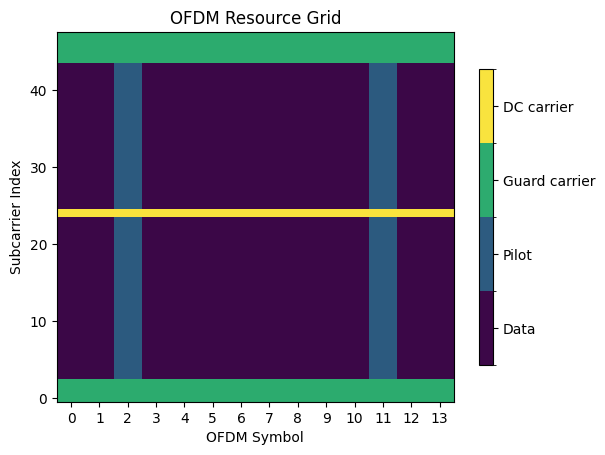

In [12]:
num_ofdm_symbols = 14
fft_size = 12*4 # 70 PRBs
scs = 120e3 # Hz
CARRIER_FREQUENCY = 10e9 # Hz
SPEED = 0 # m/s
Fs = fft_size * scs
num_tx = 1
num_streams_per_tx = 2
num_guard_carriers = [3, 4] 
cp_len  = 2

rg = ResourceGrid(num_ofdm_symbols=num_ofdm_symbols,
                  fft_size=fft_size,
                  subcarrier_spacing=scs,
                  num_tx=num_tx,
                  num_streams_per_tx=num_streams_per_tx,
                  cyclic_prefix_length=cp_len,
                  num_guard_carriers= num_guard_carriers,
                  dc_null=True,
                  pilot_pattern="kronecker",
                  pilot_ofdm_symbol_indices=[2,11])
rg.show();

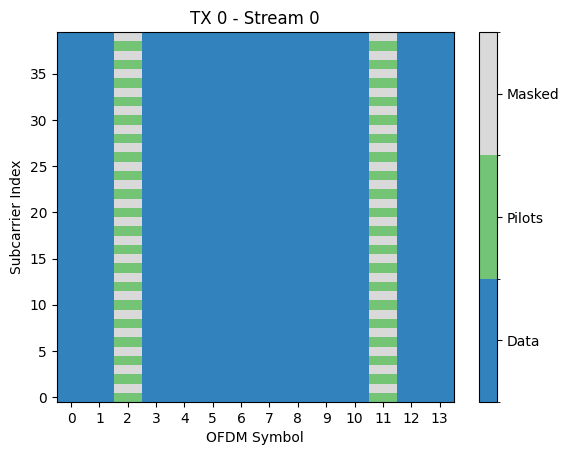

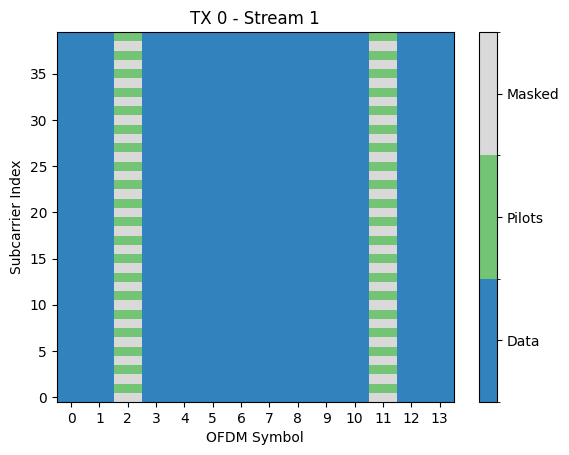

In [13]:
rg.pilot_pattern.show();

In [ ]:

# # ---------------------------
# # Parameters
# # ---------------------------
# num_ofdm_symbols   = 14
# fft_size           = 12*70               # 4 PRBs × 12 subcarriers = 48
# subcarrier_spacing = 120e3               # 30 kHz
# num_tx             = 1                  # one transmitter
# num_streams_per_tx = 1                  # one stream per transmitter
# guard              = [3,3]              # 3 guard carriers on each side
# dcnull             = True               # remove the DC carrier
# pilot_syms_idx     = [2, 11]            # pilot OFDM symbol indices
# comb_step          = 2                  # comb spacing = every 2nd subcarrier

# # ---------------------------
# # Step 1: Create a base ResourceGrid
# # (only to query the number of effective subcarriers, i.e., excluding guards/DC)
# # ---------------------------
# rg_base = ResourceGrid(num_ofdm_symbols=num_ofdm_symbols,
#                        fft_size=fft_size,
#                        subcarrier_spacing=subcarrier_spacing,
#                        num_tx=num_tx,
#                        num_streams_per_tx=num_streams_per_tx,
#                        cyclic_prefix_length=6,
#                        num_guard_carriers=guard,
#                        dc_null=dcnull,
#                        pilot_pattern="kronecker",             # placeholder
#                        pilot_ofdm_symbol_indices=pilot_syms_idx)

# NES = rg_base.num_effective_subcarriers   # number of effective subcarriers

# # ---------------------------
# # Step 2: Build a custom pilot mask
# # Shape: [num_tx, num_streams, num_ofdm_symbols, num_effective_subcarriers]
# # ---------------------------
# mask = np.zeros((num_tx, num_streams_per_tx, num_ofdm_symbols, NES), dtype=bool)

# for t in range(num_tx):
#     for s in range(num_streams_per_tx):
#         # Offset can be used if you have multiple streams (frequency-domain shift).
#         offset = s % comb_step
#         # Select subcarrier indices with comb spacing
#         cols = np.arange(offset, NES, comb_step)
#         # Mark chosen subcarriers as pilots for the selected OFDM symbols
#         for l in pilot_syms_idx:
#             mask[t, s, l, cols] = True

# # ---------------------------
# # Step 3: Define pilot symbols
# # The number of pilots is the number of True entries per stream
# # PilotPattern will map symbols in ascending (time, frequency) order
# # ---------------------------
# num_pilots_per_stream = int(mask[0,0].sum())
# pilots = np.zeros((num_tx, num_streams_per_tx, num_pilots_per_stream), np.complex64)
# pilots[:] = 1.0 + 0.0j    # assign all pilots to constant symbol (1+0j)

# # ---------------------------
# # Step 4: Create PilotPattern and ResourceGrid with the custom pilots
# # ---------------------------
# pp = PilotPattern(mask, pilots)

# rg = ResourceGrid(num_ofdm_symbols=num_ofdm_symbols,
#                   fft_size=fft_size,
#                   subcarrier_spacing=subcarrier_spacing,
#                   num_tx=num_tx,
#                   num_streams_per_tx=num_streams_per_tx,
#                   cyclic_prefix_length=6,
#                   num_guard_carriers=guard,
#                   dc_null=dcnull,
#                   pilot_pattern=pp)

# # ---------------------------
# # Step 5: Visualization
# # ---------------------------
# rg.pilot_pattern.show()   # visualize pilot pattern only
# # rg.show()               # visualize the full resource grid (data + pilots + guards + DC)


In [ ]:

def ensure_batch_dim(a, tau):
    
    if a.ndim == 6:  # [R,Ra,T,Ta,L,Nt] → add batch
        a = a[np.newaxis, ...]
    elif a.ndim != 7:
        raise ValueError(f"Unexpected a.ndim={a.ndim}, expect 6 or 7")
    
    if tau.ndim in (3, 5):  # [R,T,L] or [R,Ra,T,Ta,L] → add batch
        tau = tau[np.newaxis, ...]
    elif tau.ndim not in (4, 6):  # [B,R,T,L] or [B,R,Ra,T,Ta,L]
        raise ValueError(f"Unexpected tau.ndim={tau.ndim}, expect 3/4/5/6")
    
    return a, tau

In [ ]:
a, tau = ensure_batch_dim(a, tau)
frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)
h_freq = cir_to_ofdm_channel(frequencies, a, tau, normalize=False)
h_freq.shape

In [ ]:
EkT_dBm_per_Hz = -174     # dBm/Hz
NF_dB = 2
N0_dBm = EkT_dBm_per_Hz + 10*np.log10(scs) + NF_dB
N0_bs = 10**((N0_dBm - 30)/10)   # in Watts

In [ ]:
apply_channel = ApplyOFDMChannel()
# y = apply_channel([x, h_freq, N0_bs])